# Семинар №3 (4) 
# Прогнозируем возврат пользователя в следующие 30 дней

Что мы делаем:
1. Готовим данные и создаем таргет относительно задания.
2. Делаем фичеинжиниринг.
3. Обучаем модели.
4. Ищем оптимальные параметры.


Работу продолжаем с тем же датасетом, что у нас был на первых семинарах. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_csv('./sem01/google_log.csv',
                      sep = '\t',
                      na_values=[None, '(not provided)', 'not available in demo dataset'])

In [ ]:
dataset.head()

__Описание колонок:__ 


- `date` дата посещения сайта (рассматривается период с 20160801 по 20170801
- `fullVisitorId` уникальный id пользователя
- `sessionId` уникальный id одной пользовательской сессии
- `channelGrouping` откуда произошёл переход
- `visitStartTime` timestamp начала визита
- `device.browser` браузер визита
- `device.operatingSystem` операционная система устройства
- `device.isMobile` является ли устройство мобильным
- `device.deviceCategory` тип устройства (айпад, компьютер, мобильный телефон)
- `geoNetwork.subContinent` часть света пользователя
- `geoNetwork.country` страна пользователя
- `geoNetwork.region` регион пользователя
- `geoNetwork.city` город пользователя
- `totals.hits` похоже что это действия на сайте, но это неточно
- `totals.pageviews` просмотры страниц
- `totals.transactionRevenue` выручка с покупки
- `trafficSource.source` источник трафика
- `trafficSource.medium` более высокоуровневый источник трафика
- `trafficSource.keyword` ключевые слова из поиска
- `trafficSource.adwordsClickInfo.adNetworkType` несколько переменных с дополнительной информацией из adwords
- `trafficSource.adwordsClickInfo.page`
- `trafficSource.adwordsClickInfo.slot`
- `trafficSource.adwordsClickInfo.isVideoAd` 
- `trafficSource.adContent`

# 1. Готовим данные

## Анализируем пропуски

In [ ]:
100*dataset.isnull().sum() / dataset.shape[0]

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

sns_heatmap = sns.heatmap(dataset.sample(5000).isnull(), 
                          yticklabels=False, 
                          cbar=False, 
                          cmap='viridis')

In [ ]:
dataset.isnull().sum()

__Задание 1:__

Удалите колонки `'trafficSource.keyword', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.adContent'`.  В них допущено слишком много пропусков и они неинформативны для нас. 

In [ ]:
# ваш код

__Задание 2:__

Создайте новую колонку `isRevenue`. Положите в неё $1$, если человек сделал покупку на сайте и $0$, если нет.

In [ ]:
# ваш код

__Задание 3:__

Нормальная ситуация в боевых задачах - отсутствие явного таргета: чтобы прогнозировать отток, надо договариваться, что мы понимаем под оттоком и размечать клиентскую базу на тех, кто в оттоке и не в оттоке.

Нас просят спрогнозировать вероятность второго посещения пользователем. Готовой колонки, было ли повторное посещение, у нас нет. Но есть много данных, из которых можно создать интересующий нас таргет.

---

Мы будем пытаться спрогнозировать вернётся ли пользователь после первого посещения к нам на сайт ещё раз в течение следующих $30$ дней. Подготовимся к созданию колонки с таргетом. 

Создайте колонку с датой первого визита. 



In [ ]:
# ваш код

Найдите для каждой строки таблицы время, которое прошло от даты первого визита до текущего в днях. Запишите его в отдельную колонку. 

In [ ]:
# ваш код

Создайте колонку `isIn30days`. Если строка в таблице соотвествует возвращению человека в течение $30$ дней, запишите в неё $1$.

In [ ]:
# ваш код

Отлично, около каждого второго визита, который укладывается в нужный нам диапазон, теперь стоит $1$. Давайте создадим подтаблицу с id всех тех людей, которые вернулись. 

In [ ]:
dataset_back = dataset.groupby('fullVisitorId').agg({'isIn30days' : 'sum'})
dataset_back.columns = ['is_back']
dataset_back.head()

In [ ]:
dataset = dataset.merge(dataset_back, how = 'inner', on = 'fullVisitorId')

Остался последний штрих. Мы собираемся прогнозировать вернётся ли человек к нам во второй раз по его первому посещению. Для этого нам в нашей табличке надо оставить только те строки, которые соотвествуют первым визитам.

In [ ]:
dataset = dataset[dataset['date'] == dataset['first_visit_date']]

In [ ]:
dataset['is_back'] = 1*(dataset['is_back'] > 0)
dataset.shape

In [ ]:
dataset.is_back.value_counts()

In [ ]:
dataset.drop(['first_visit_date','diff_with_first_visit_date','isIn30days'], axis=1, inplace=True)

In [ ]:
dataset.head()

Теперь поработаем с объясняющими переменными, на основе которых мы будем пытаться построить прогнозы.  Давайте немного структурируем все те данные, которые у нас есть.

## Категориальные переменные

Большая часть колонок, которая есть у нас в рассмотрении - категориальные переменные.

In [ ]:
dataset.dtypes

In [ ]:
var_cat = ['channelGrouping', 'device.browser', 'device.operatingSystem', 'device.deviceCategory',
           'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.city',
           'trafficSource.source', 'trafficSource.medium']

In [ ]:
dataset[var_cat].head()

Чтобы по категориальным переменным можно было строить прогнозы, с ними обычно делают OHE-кодирование, то есть превращают их в набор из перменнымх, принимающих значения $0$ или $1$. К сожалению, в ситуациях, когда переменная может принимать очень много значений, такой подход слишком сильно раздувает табличку с данными. 

In [ ]:
sns.countplot(x='device.browser', data=dataset);

In [ ]:
# для device.browser в максимальной категории 620364 наблюдения
dataset['device.browser'].value_counts()[:10]  

In [ ]:
# В минимальной категории 1 наблюдение
dataset['device.browser'].value_counts()[-10:]  

Для ситуаций, когда есть огромное число категорий и какие-то из них очень мелкие, заводят категорию "другое", куда сваливают всё то, что не попало в большие категории. Давайте ровно это тут и сделаем.

In [ ]:
uniq_category = dataset['device.browser'].unique()  # Уникальные категории
uniq_category

In [ ]:
# Смотрим какие из них большие
counts = dataset['device.browser'].value_counts()
big_category = counts[counts > 5000].index
big_category

In [ ]:
# Вычитаем из множества уникальных множество больших
small_category = list(set(uniq_category) - set(big_category))
small_category[:10]

Заменим все маленькие категории из таблицы на категорию `another`

In [ ]:
dataset['device.browser'] = (
    dataset['device.browser'].apply(
    lambda w: 'another' if w in small_category else w)
)

In [ ]:
dataset['device.browser'].value_counts()

Дальше мы можем сделать для этой колонке OHE и табличка раздуется не очень слиьно. 

In [ ]:
pd.get_dummies(dataset['device.browser'], drop_first=True, dummy_na=True)

### Задание: 

А теперь напишите функцию, которая будет делать все эти действия для произвольной колонки. 

In [ ]:
# ваш код

С помощью цикла пройдёмся по все колонкам с категориями. 

In [ ]:
# ваш код

# 2. Фичеинжиниринг.
## 2.1. Действительные переменные 

In [ ]:
var_real = ['totals.hits', 'totals.pageviews']
dataset[var_real].hist(figsize=(12,4));

### Задание:  

Прологарифмируйте действительные переменные и перезапишите их. Вспомните, зачем это имеет смысл делать. 

In [ ]:
# ваш код

## 2.2. Переменные, связанные со временем

В переменных `date` и `visitStartTime` лежит информация про время визита. На прошлых семинарах мы довольно много работали со временем. Давайте придумаем какие переменные можно создать на его основе и добавим их в таблицу. 

In [ ]:
# сразу сделаем их категориальными
dataset["visitDay"] = dataset['date'].dt.day.astype(str)             # день визита
dataset["visitMonth"] = dataset['date'].dt.month.astype(str)         # месяц визита
dataset["visitWeekday"] = dataset['date'].dt.weekday.astype(str)     # выходные


# начало и конец месяца
dataset["is_month_start"] = dataset['date'].dt.is_month_start
dataset["is_month_end"] = dataset['date'].dt.is_month_end

In [ ]:
from datetime import datetime
dataset['visitHour'] = (dataset['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)).astype(str)

In [ ]:
dataset.head()

## 2.3. Хитрые переменные

Попробуем создать более хитрые переменные. Например, в переменной `totals.pageviews` лежит логарифм числа просмотров страниц на сайте. А в переменной `isRevenue` информация о том, сделал ли человек покупку. Перемножьте эти две переменные между собой. Новая переменная будет показывать сколько страниц на сайте просматривают те люди, которые делают покупки. 

---

Синтетические фичи можно создавать всеми возможными математическими операциями. Главное, чтобы вы могли объяснить их смысл.

In [ ]:
dataset['rev.pageviews'] = dataset['isRevenue'] * dataset['totals.pageviews']

### Задание:  
 
Постарайтесь придумать ещё несколько подобных сложных переменных, которые помогли бы нам в прогнозировании. 

In [ ]:
# ваш код

## 2.4. Финальные штрихи 

Выбросим все технические переменные и сделаем OHE-преобразование. 

In [ ]:
var_drop = ['date', 'visitStartTime', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue' ]
dataset.drop(var_drop, axis=1, inplace=True)
dataset.head()

In [ ]:
dataset.shape

In [ ]:
df = pd.get_dummies(dataset, drop_first=True, dummy_na=True)
df.shape

In [ ]:
df.head()

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.shape

# 3. Обучаем модели


### Решающее дерево

- Обучите решающее дерево
- Проверьте качество прогноза на тестовой выборке
- Проверьте переобученность модели (сравните значения метрик на тестовой и тренировочной выборке)

Модель представлена в виде функции **DecisionTreeClassifier** в модуле sklearn.tree

### Случайный лес

- Обучите случайный лес
- Проверьте качество прогноза на тестовой выборке
- Проверьте переобученность модели (сравните значения метрик на тестовой и тренировочной выборке)

Модель представлена в виде функции **RandomForestClassifier** в модуле sklearn.ensemble


В качестве метрики используйте f1-меру (подумайте, почему)

In [ ]:
# ваш код

## Дерево решений

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

Создаем модель и обучаем её.

In [ ]:
# ваш код

Прогнозируем и считаем метрику прогноза

In [ ]:
# ваш код

## Случайный лес

Создаем модель и обучаем её.

In [ ]:
# ваш код

Прогнозируем и считаем метрику прогноза

In [ ]:
# ваш код

## 4. Подбор гиперпараметров для решающего дерева

Вместе с однокурсниками по zoom-залу:
- выберите два гиперпараметра, которые будете оптимизировать
- определите список перебираемых значений
- организуйте поиск по решетке
- Для лучшей модели сравните значения метрик с дефолтными моделями

В документации можно найти весь список параметров, мы вынесли сюда из основных:

- **criterion** {“gini”, “entropy”}, default=”gini” <br>
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

- **max_depth**: default=0 <br>
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- **min_samples_split**: int or float, default=2 <br>
The minimum number of samples required to split an internal node:

- **min_samples_leaf**: int or float, default=1 <br>
The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

- **max_features**: int, float or {“auto”, “sqrt”, “log2”}, default=None <br>
The number of features to consider when looking for the best split:

- **max_leaf_nodes**: int, default=None <br>
Grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

- **min_impurity_decrease**: float, default=0.0 <br>
A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

- **min_impurity_split**: float, default=0 <br>
Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.

## Подбор гиперпараметров по решетке

Поиск по решетке - один из способов найти оптимальные значения гиперпараметров. Идея в том, чтобы пройтись по всем значениям и посмотреть, на каком из них достигается лучший результат.

Поиск лучшего значения гиперпараметра делается одновременно с кросс-валидацией

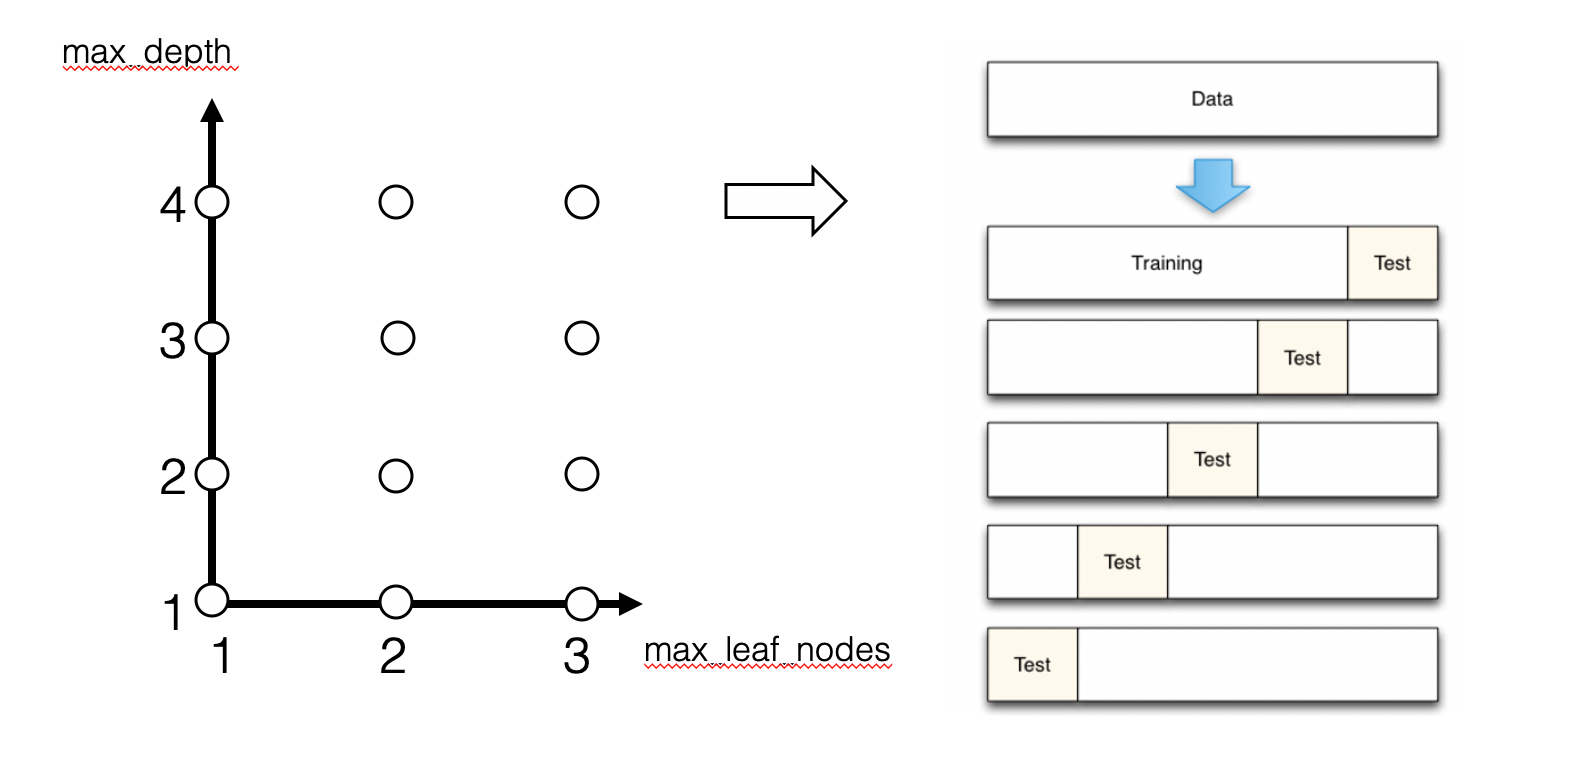

Основные параметры функции GridSearchCV для запуска:

- **estimator**: модель, которая проходит валидацию
- **param_grid**: параметры, которые перебираем
- **scoring**: метрика, по которой оцениваем качество
- **cv**: стратегия кросс-валидации (сколько фолдов)
- **return_train_score**: флаг, который вернет значение метрики и на тренировочной выборке

Основные методы:
- **fit**: запуск поиска по решетке
- **predict**: прогноз лучшей моделью
- **predict_proba**: прогноз вероятностей (если модель позволяет их прогнозировать)
- **score**: качество модели

Основные поля grid_tree после обучения:
- **cv_results_**
- **best_estimator_**
- **best_score_**
- **best_params_**
- **scorer_**
- **n_splits_**

In [ ]:
### ваш код